In [1]:
import numpy as np
import os
# from PIL import Image
import pickle
# from sum_all_images import Threading_read_images
import time
from functools import reduce
from operator import add
import matplotlib.pyplot as plt
# from scipy.sparse import issparse
# import inspect
# import re

from utils import get_def_name, get_tags_from_first_tiff, get_tiff_list
from multi_threading import Threading_read_images, parallel_exponentiate_RMS, parallel_sum

### Functions

RMS_image_array_csr.pkl 108MB

RMS_image_array.pkl 72MB

In [2]:
"""
Hello world
"""

# Write a copy of read_all_images() here
def read_all_images_RMS(tiff_path, **kwargs):
    debugging = kwargs.get('debugging', True)
    pickle_usage = kwargs.get('pickle_usage', True)

    image_arrays = []
    start_time = time.time()
    if debugging==True and pickle_usage==False:
        print('NOT USING PICKLE')
    
    if os.path.exists(f'{tiff_path}\\image_arrays.pkl') and pickle_usage==True:
        with open(f'{tiff_path}\\image_arrays.pkl', 'rb') as f:
            image_arrays = pickle.load(f)
        print(f'{tiff_path}\nLoaded image_arrays.pkl')
    else:
        image_arrays = Threading_read_images(tiff_path)

        if pickle_usage==True:
            with open(f'{tiff_path}\\image_arrays.pkl', 'wb') as f:
                pickle.dump(image_arrays, f)

    end_time = time.time()
    if debugging==True:
        print(f'File reading time: {end_time - start_time:.1f} seconds. With {get_def_name()}')


    return image_arrays

# Mirror of sum_array_dense()
# Should create a dense sparse matrix output
def get_RMS_array_dense(tiff_path, **kwargs):
    debugging = kwargs.get('debugging', False)
    pickle_usage = kwargs.get('pickle_usage', True)
    
    image_arrays = read_all_images_RMS(tiff_path, **kwargs)
    start_time = time.time()
    if debugging==True and pickle_usage==False:
        print('NOT USING PICKLE')

    if os.path.exists(f'{tiff_path}\\RMS_image_array.pkl') and pickle_usage==True:
        with open(f'{tiff_path}\\RMS_image_array.pkl', 'rb') as f:
            # RMS_array_csr = pickle.load(f)
            RMS_array = pickle.load(f)
        print('Loaded RMS_image_array.pkl')

        # # if RMS_array is csr sparse, convert it to dense
        # if issparse(RMS_array):
        #     RMS_array = RMS_array.toarray()
        #     with open(f'{tiff_path}\\RMS_image_array.pkl', 'wb') as f:
        #         pickle.dump(RMS_array, f)
    
    else:

        squaring_start_time = time.time()
        # square = [img.power(2) for img in image_arrays]
        square = parallel_exponentiate_RMS(image_arrays, 2)

        squaring_end_time = time.time()
        if debugging==True:
            print(f'Squaring time: {squaring_end_time - squaring_start_time:.1f} seconds. With {get_def_name()}')


        adding_start_time = time.time()
        # RMS_array_csr = (reduce(add, square) / len(square)).power(0.5)
        RMS_array_csr = (parallel_sum(square) / len(square)).power(0.5)

        adding_end_time = time.time()
        if debugging==True:
            print(f'Adding time: {adding_end_time - adding_start_time:.1f} seconds. With {get_def_name()}')


        if debugging==True:
            # print(f'Total RMS_array elements: {RMS_array_csr.size}')    # 开什么玩笑，要吐了！应该直接取Image Dimension!
            _, image_width, image_length = get_tags_from_first_tiff(tiff_path)[:3]
            total_pixel_amount = image_width * image_length
            print(f'Total RMS_array elements: {total_pixel_amount}')
            print(f'Non-zero RMS_array elements: {RMS_array_csr.nnz}')
            print(f'Zero RMS_array elements: {total_pixel_amount - RMS_array_csr.nnz}')


        RMS_array = RMS_array_csr.toarray()
        if pickle_usage==True:
            with open(f'{tiff_path}\\RMS_image_array.pkl', 'wb') as f:
                pickle.dump(RMS_array, f)

            # with open(f'{tiff_path}\\RMS_image_array_csr.pkl', 'wb') as f:
            #     pickle.dump(RMS_array_csr, f)

    end_time = time.time()
    print(f'RMS calculation time: {end_time - start_time:.1f} seconds. With {get_def_name()}')

    return RMS_array

# For debugging. Deprecated
# def add_pixel(image_arrays, **kwargs):

#     # square = [img.power(2) for img in image_arrays]
#     # RMS = (reduce(add, square) / len(square)).power(0.5)
#     RMS = reduce(add, image_arrays)

#     return RMS

### Write a copy of plot_SUM() to plot RMS

In [3]:
def plot_RMS(RMS_array, tiff_path, **kwargs):
    plot_type = kwargs.get('plot_type', 'bar')
    debugging = kwargs.get('debugging', True)
    bin_amount = kwargs.get('bin_amount', 100)
    save = kwargs.get('save', False)

    start_time = time.time()
    tiff_filenames = get_tiff_list(tiff_path)

    # RMS_array = RMS_array_csr.toarray()

    # caption_tags, image_width, image_length = get_tags_from_first_tiff(tiff_path)
    caption_tags, image_width, image_length, exposure_time_ms = get_tags_from_first_tiff(tiff_path)[:4]
    total_pixel_amount = image_width * image_length

    caption_statistics_RMS = f'{np.sum(RMS_array==0)} pixels had 0 count in the whole set of data, {np.sum(RMS_array==0) / total_pixel_amount * 100:.1f}%; \n' + \
            f'RMS(10% of the pixels) <= {np.percentile(RMS_array, 10)}; \n' + \
            f'RMS(90% of the pixels) <= {np.percentile(RMS_array, 90)}'


    if plot_type == 'bar':
        counts, bin_edges = np.histogram(RMS_array.flatten(), bins=bin_amount)

        if debugging==True:
            # print(f'bin amount: {bin_amount}')
            print(f'bins width: {np.average(np.diff(bin_edges))}')
            max_fraction_bin = np.max(counts) / np.sum(counts)
            print(f'{100*max_fraction_bin:.1f}% of pixel RMS errors fall between '
                f'{np.argmax(counts)} and {np.argmax(counts) + np.diff(bin_edges)[0]} counts in all {len(tiff_filenames)} frames')

        counts_normalized = counts / counts.max()

        fig = plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], counts_normalized, width=np.diff(bin_edges), color='gray', log=True, align='edge')

        plt.xlabel('RMS')
        plt.ylabel('Frequency (normalized)')
        
        fig.text(0.15, 0.05, caption_tags + caption_statistics_RMS, ha='left')
        plt.subplots_adjust(bottom=0.25)

        # if save==True:
        #     plt.savefig('RMS_bar.png')

        # plt.show()

    elif plot_type == 'heat':
        # Standard plot dimension width, length (10, 6)
        # Fix width, adjust length
        heat_plot_width = np.round(image_width/image_length * 6, 1)
        fig = plt.figure(figsize=(heat_plot_width, 6))
        
        # plt.imshow(RMS_array, cmap='hot', interpolation='nearest')
        plt.imshow(RMS_array, cmap='hot')
        plt.colorbar(label='RMS')
        fig.text(0.15, 0.05, caption_tags + caption_statistics_RMS, ha='left')
        plt.subplots_adjust(bottom=0.2)
        # if save==True:
        #     plt.savefig(f'RMS_{plot_type}_{exposure_time_ms}ms_{image_width}x{image_length}.png')
        # plt.show()

    if save==True:
        plt.savefig(f'RMS_{plot_type}_{exposure_time_ms}ms_{image_width}x{image_length}.png')
    plt.show()

    end_time = time.time()
    if debugging==True:
        print(f'Plotting time: {end_time - start_time:.1f} seconds')

### Testing

NOT USING PICKLE

File reading time: 784.8 seconds. With DEF read_all_images_RMS()


##### Square multi-processed \\full_1s_6000_shot

Squaring time: 60.8 seconds. With DEF get_RMS_array_dense()

Adding time: 179.4 seconds. With DEF get_RMS_array_dense()

##### Square & Adding \\full_1s_6000_shot

Squaring time: 71.9 seconds. With DEF get_RMS_array_dense()

Adding time: 124.0 seconds. With DEF get_RMS_array_dense()

C:\3.12 qCMOS\full_1s_6000_shot
Loaded image_arrays.pkl
File reading time: 6.2 seconds. With DEF read_all_images_RMS()
Squaring time: 71.9 seconds. With DEF get_RMS_array_dense()
Adding time: 124.0 seconds. With DEF get_RMS_array_dense()
Total RMS_array elements: 9437184
Non-zero RMS_array elements: 9436534
Zero RMS_array elements: 650
RMS calculation time: 196.5 seconds. With DEF get_RMS_array_dense()
Max element: 3.300606004963331
Min element: 0.0
Min non-zero element: 0.012909944487358056


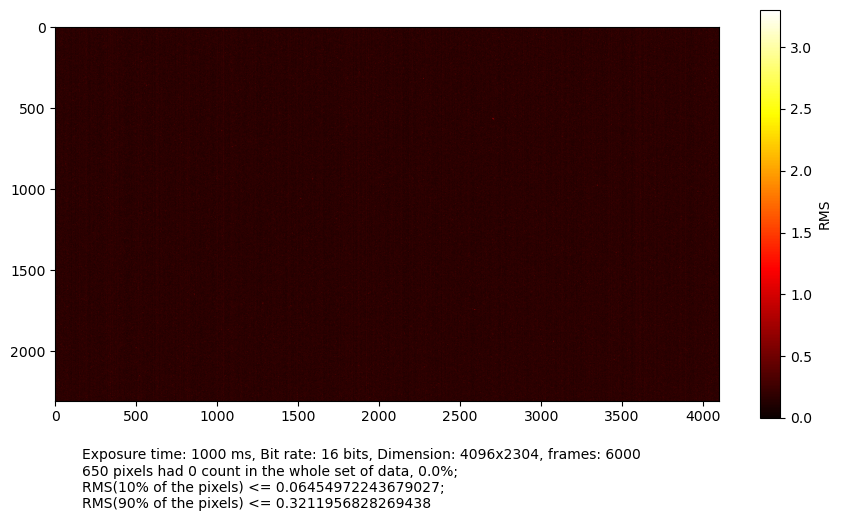

Plotting time: 1.5 seconds
bins width: 0.03300606004963331
23.3% of pixel RMS errors fall between 2 and 2.033006060049633 counts in all 6000 frames


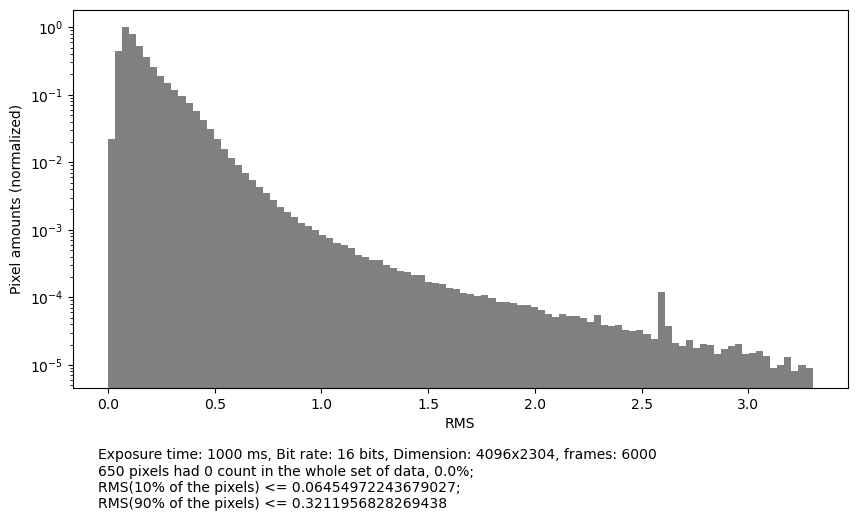

Plotting time: 1.5 seconds


In [4]:
tiff_main_folder = 'C:\\3.12 qCMOS'
tiff_path = tiff_main_folder + '\\full_1s_6000_shot'
# tiff_path = tiff_main_folder + '\\full_frame_quick'
# tiff_path = tiff_main_folder + '\\full_frame'
# tiff_path = tiff_main_folder + '\\full_200ms_6247shots'
# tiff_path = tiff_main_folder + '\\1024x1024'
# NOT USING PICKLE
# File reading time: 784.8 seconds. With DEF read_all_images_RMS()


RMS_array = get_RMS_array_dense(tiff_path, debugging=True)
print('Max element:', RMS_array.max())
print('Min element:', RMS_array.min())
print('Min non-zero element:', RMS_array[RMS_array > 0].min())

# print(f'issparse(RMS_array)? {issparse(RMS_array)}')
plot_RMS(RMS_array, tiff_path, plot_type='heat', save=True)
plot_RMS(RMS_array, tiff_path, plot_type='bar', save=True)